<a href="https://colab.research.google.com/github/EASC/tvdi_hpc/blob/main/tp_final_fonnegra_solarte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/cursos/HPC/tp_final/code

Mounted at /content/gdrive
/content/gdrive/MyDrive/cursos/HPC/tp_final/code


In [15]:
from time import time, sleep
import multiprocessing as mp
import threading as thr
import numpy as np
from osgeo import gdal
from gdalconst import *
from scipy import stats
import sys
import os

def load_img(filename):

    ds = gdal.Open(filename, gdal.GA_ReadOnly)
    sds = ds.GetRasterBand(1)
    nodata = sds.GetNoDataValue()
    sds_array = sds.ReadAsArray()
    sds_array[sds_array==nodata] = np.nan
    sds_array = sds_array[:2010, :]
    rows, cols = sds_array.shape

    dict_data = {'array': sds_array,
                 'geoTs': ds.GetGeoTransform(),
                 'proj': ds.GetProjection(),
                 'rows': rows,
                 'cols': cols
                 }

    return dict_data

def save_img(fname, array, rows, cols, geoTs, proj, bands=1, dtype=GDT_Float32):
    #Salida de la imagen georreferenciada
    driver = gdal.GetDriverByName("GTiff") #Tipo de imagen (geotiff)
    print("creando imagen")
    #Crear el espacio
    export = driver.Create(fname, cols, rows, bands, dtype)
    banda = export.GetRasterBand(1) #Cargar la banda creada en el paso anterior
    banda.WriteArray(array) #Escribir array en la imagen
    export.SetGeoTransform(geoTs) #Asignar los parametros de transformacion
    export.SetProjection(proj) #Definir la proyección
    banda.FlushCache() #Descargar de la memoria virtual al disco
    export.FlushCache() #Descargar de la memoria virtual al disco

def extract_dry_limit(ndvi, lst, vmin, vmax, px):
    #Valores que están en el delta definido
    vals = np.where((ndvi > vmin) & (ndvi <= vmax))
    lst_arr = lst[vals]
    ndvi_arr = ndvi[vals]
        
    #Ordenar los valores según mayor temperatura
    indices = lst_arr.argsort()
    lst_arr = lst_arr[indices]
    ndvi_arr = ndvi_arr[indices]
    tmin, lst_max, ndvi_max = None, None, None

    if len(ndvi_arr)>0:
        tmin = lst_arr[0] #Valores bajos de la dispersión (límite húmedo)
        lst_max = lst_arr[-px:][0] #Valores altos de la dispersión (límite seco)
        ndvi_max = ndvi_arr[-px:][0] #Valor equivalente NDVI (límite seco)
    
    return tmin, lst_max, ndvi_max

def calc_tvdi(q, ndvi, lst, min_ndvi, max_ndvi, delta, px, pos):
    #Listas para almacenar los valores de lst y ndvi para la regresión
    lst_regr = []
    ndvi_regr = []
    tmin = []

    #Eliminar valores nulos
    nan_data = ~np.isnan(lst)
    nan_data2 = ~np.isnan(ndvi)
    nan_data = nan_data*nan_data2

    lst_C_reshape = lst[nan_data]
    ndvi_reshape = ndvi[nan_data]
    
    for v in np.arange(min_ndvi, max_ndvi, delta):
        dry_limit = extract_dry_limit(ndvi_reshape, lst_C_reshape, v, v+delta, px)
        
        if all(dry_limit):
            tmin.append(dry_limit[0])
            lst_regr.append(dry_limit[1])
            ndvi_regr.append(dry_limit[2])
    
    tmin = np.array(tmin)
    lst_regr = np.array(lst_regr)
    ndvi_regr = np.array(ndvi_regr)
    #Regresión lineal
    slope, intercept, r_val, p_val, std_err = stats.linregress(ndvi_regr, lst_regr)

    #Cálculo del TVDI
    tvdi = (lst - np.mean(tmin)) / (intercept + slope*ndvi - np.mean(tmin))

    q.put([tvdi, pos])
    
def main_tvdi(im_ndvi, im_lst, im_tvdi, w_height=2000, min_ndvi=0, px=1, delta=0.01):
    '''
    im_ndvi: nombre y ruta de imagen de entrada de NDVI
    im_lst: nombre y ruta de imagen de entrada de LST
    im_tvdi: nombre y ruta de salida de imagen TVDI
    w_height: alto de ventana para cálculo del índice
    min_ndvi: límite inferior de corte del histograma para calcular límite seco
    px: cantidad de pixeles de LST a tener en cuenta (límite seco)
    delta: define el paso durante la iteración
    '''
    q = mp.Queue()

    #cargar imágenes
    ndvi = load_img(im_ndvi)
    lst = load_img(im_lst)
    lst['array'][lst['array']<=0] = np.nan

    ################################
    array_tvdi = np.empty_like(ndvi['array'])
    
    #Parámetros
    max_ndvi = np.nanmax(ndvi['array'])
    process = list()
    for i in range(0, ndvi['rows']-w_height+1):
        if i%500==0:
            print(f'fila {i} a {i + w_height}: calculando deltas')
        ndvi_sub = ndvi['array'][i:i+w_height, :]
        lst_sub = lst['array'][i:i+w_height, :]
        
        # t = thr.Thread(target=calc_tvdi, args=(q, ndvi_sub, lst_sub, min_ndvi, max_ndvi, delta, px, i, ))
        t = mp.Process(target=calc_tvdi, args=(q, ndvi_sub, lst_sub, min_ndvi, max_ndvi, delta, px, i, ))
        t.start()
        process.append(t)

    for i in range(len(process)):

        tvdi_sub, pos = q.get()
        
        idx = w_height//2

        if pos==0:
            array_tvdi[:idx+1, :] = tvdi_sub[:idx+1, :]
        elif pos+w_height==ndvi['rows']:
            array_tvdi[pos+idx:, :] = tvdi_sub[idx:, :]
        else:
            array_tvdi[pos+idx, :] = tvdi_sub[idx, :]
    
    for t in process: 
        t.join()

###########################################

    save_img(im_tvdi, array_tvdi, ndvi['rows'], ndvi['cols'], ndvi['geoTs'], ndvi['proj'])

In [16]:
if __name__ == '__main__':
    a = time()
    P = mp.cpu_count()

    ndvi_fn = '../data/input/ndvi_2022209_500m.tif'
    lst_fn = '../data/input/lst_Celsius_2022209_500m.tif'
    output_tvdi = '../data/output/tvdi_2022209_500m_fn_op.tif'
    main_tvdi(ndvi_fn, lst_fn, output_tvdi)
    b = time()
    print(f'Ejecución finalizada en {b - a} segundos')

fila 0 a 2000: calculando deltas
creando imagen
Ejecución finalizada en 12.80885624885559 segundos


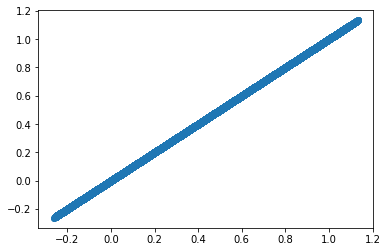

In [17]:
import matplotlib.pyplot as plt

ds = gdal.Open('../data/output/tvdi_2022209_500m_fn_op.tif')
ds2 = gdal.Open('../data/output/tvdi_2022209_500m_fn2.tif')
sds = ds.ReadAsArray()
sds2 = ds2.ReadAsArray()

plt.scatter(sds.flatten(), sds2.flatten())
plt.show()

In [18]:
from time import time, sleep
import multiprocessing as mp
import threading as thr
import numpy as np
from osgeo import gdal
from gdalconst import *
from scipy import stats
import sys
import os

def load_img(filename):

    ds = gdal.Open(filename, gdal.GA_ReadOnly)
    sds = ds.GetRasterBand(1)
    nodata = sds.GetNoDataValue()
    sds_array = sds.ReadAsArray()
    sds_array[sds_array==nodata] = np.nan
    sds_array = sds_array[:2010, :]
    rows, cols = sds_array.shape

    dict_data = {'array': sds_array,
                 'geoTs': ds.GetGeoTransform(),
                 'proj': ds.GetProjection(),
                 'rows': rows,
                 'cols': cols
                 }

    return dict_data

def save_img(fname, array, rows, cols, geoTs, proj, bands=1, dtype=GDT_Float32):
    #Salida de la imagen georreferenciada
    driver = gdal.GetDriverByName("GTiff") #Tipo de imagen (geotiff)
    print("creando imagen")
    #Crear el espacio
    export = driver.Create(fname, cols, rows, bands, dtype)
    banda = export.GetRasterBand(1) #Cargar la banda creada en el paso anterior
    banda.WriteArray(array) #Escribir array en la imagen
    export.SetGeoTransform(geoTs) #Asignar los parametros de transformacion
    export.SetProjection(proj) #Definir la proyección
    banda.FlushCache() #Descargar de la memoria virtual al disco
    export.FlushCache() #Descargar de la memoria virtual al disco

def extract_dry_limit(ndvi, lst, vmin, vmax, px):
    #Valores que están en el delta definido
    vals = np.where((ndvi > vmin) & (ndvi <= vmax))
    lst_arr = lst[vals]
    ndvi_arr = ndvi[vals]
        
    #Ordenar los valores según mayor temperatura
    indices = lst_arr.argsort()
    lst_arr = lst_arr[indices]
    ndvi_arr = ndvi_arr[indices]
    tmin, lst_max, ndvi_max = None, None, None

    if len(ndvi_arr)>0:
        tmin = lst_arr[0] #Valores bajos de la dispersión (límite húmedo)
        lst_max = lst_arr[-px:][0] #Valores altos de la dispersión (límite seco)
        ndvi_max = ndvi_arr[-px:][0] #Valor equivalente NDVI (límite seco)
    
    return tmin, lst_max, ndvi_max

def calc_tvdi(q, ndvi, lst, min_ndvi, max_ndvi, delta, px, pos):
    #Listas para almacenar los valores de lst y ndvi para la regresión
    lst_regr = []
    ndvi_regr = []
    tmin = []

    #Eliminar valores nulos
    nan_data = ~np.isnan(lst)
    nan_data2 = ~np.isnan(ndvi)
    nan_data = nan_data*nan_data2

    lst_C_reshape = lst[nan_data]
    ndvi_reshape = ndvi[nan_data]
    
    for v in np.arange(min_ndvi, max_ndvi, delta):
        dry_limit = extract_dry_limit(ndvi_reshape, lst_C_reshape, v, v+delta, px)
        
        if all(dry_limit):
            tmin.append(dry_limit[0])
            lst_regr.append(dry_limit[1])
            ndvi_regr.append(dry_limit[2])
    
    tmin = np.array(tmin)
    lst_regr = np.array(lst_regr)
    ndvi_regr = np.array(ndvi_regr)
    #Regresión lineal
    slope, intercept, r_val, p_val, std_err = stats.linregress(ndvi_regr, lst_regr)

    #Cálculo del TVDI
    tvdi = (lst - np.mean(tmin)) / (intercept + slope*ndvi - np.mean(tmin))

    q.put([tvdi, pos])
    
def main_tvdi_thr(im_ndvi, im_lst, im_tvdi, w_height=2000, min_ndvi=0, px=1, delta=0.01):
    '''
    im_ndvi: nombre y ruta de imagen de entrada de NDVI
    im_lst: nombre y ruta de imagen de entrada de LST
    im_tvdi: nombre y ruta de salida de imagen TVDI
    w_height: alto de ventana para cálculo del índice
    min_ndvi: límite inferior de corte del histograma para calcular límite seco
    px: cantidad de pixeles de LST a tener en cuenta (límite seco)
    delta: define el paso durante la iteración
    '''
    q = mp.Queue()

    #cargar imágenes
    ndvi = load_img(im_ndvi)
    lst = load_img(im_lst)
    lst['array'][lst['array']<=0] = np.nan

    ################################
    array_tvdi = np.empty_like(ndvi['array'])
    
    #Parámetros
    max_ndvi = np.nanmax(ndvi['array'])
    process = list()
    for i in range(0, ndvi['rows']-w_height+1):
        if i%500==0:
            print(f'fila {i} a {i + w_height}: calculando deltas')
        ndvi_sub = ndvi['array'][i:i+w_height, :]
        lst_sub = lst['array'][i:i+w_height, :]
        
        t = thr.Thread(target=calc_tvdi, args=(q, ndvi_sub, lst_sub, min_ndvi, max_ndvi, delta, px, i, ))
        # t = mp.Process(target=calc_tvdi, args=(q, ndvi_sub, lst_sub, min_ndvi, max_ndvi, delta, px, i, ))
        t.start()
        process.append(t)

    for i in range(len(process)):

        tvdi_sub, pos = q.get()
        
        idx = w_height//2

        if pos==0:
            array_tvdi[:idx+1, :] = tvdi_sub[:idx+1, :]
        elif pos+w_height==ndvi['rows']:
            array_tvdi[pos+idx:, :] = tvdi_sub[idx:, :]
        else:
            array_tvdi[pos+idx, :] = tvdi_sub[idx, :]
    
    for t in process: 
        t.join()

###########################################

    save_img(im_tvdi, array_tvdi, ndvi['rows'], ndvi['cols'], ndvi['geoTs'], ndvi['proj'])

In [19]:
if __name__ == '__main__':
    a = time()
    P = mp.cpu_count()

    ndvi_fn = '../data/input/ndvi_2022209_500m.tif'
    lst_fn = '../data/input/lst_Celsius_2022209_500m.tif'
    output_tvdi = '../data/output/tvdi_2022209_500m_fn_op_thr.tif'
    main_tvdi_thr(ndvi_fn, lst_fn, output_tvdi)
    b = time()
    print(f'Ejecución finalizada en {b - a} segundos')

fila 0 a 2000: calculando deltas
creando imagen
Ejecución finalizada en 12.391677856445312 segundos


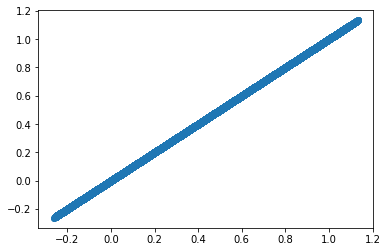

In [20]:
import matplotlib.pyplot as plt

ds = gdal.Open('../data/output/tvdi_2022209_500m_fn_op_thr.tif')
ds2 = gdal.Open('../data/output/tvdi_2022209_500m_fn2.tif')
sds = ds.ReadAsArray()
sds2 = ds2.ReadAsArray()

plt.scatter(sds.flatten(), sds2.flatten())
plt.show()